In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: ignored

In [ ]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/onetwotrip/onetwotrip_challenge_train.csv', index_col='orderid').drop(['goal21', 'goal22', 'goal23', 'goal24', 'goal25'], axis=1)
test_df = pd.read_csv('/content/drive/My Drive/onetwotrip/onetwotrip_challenge_test.csv', index_col='orderid')
sample_submission = pd.read_csv('/content/drive/My Drive/onetwotrip/onetwotrip_challenge_sub1.csv')

In [ ]:
train_df.shape, test_df.shape

((196056, 37), (455011, 36))

In [ ]:
train_df['field6'].value_counts(dropna=False)

0      152779
1        6618
3        5623
2        5579
4        4103
        ...  
323         1
150         1
101         1
102         1
126         1
Name: field6, Length: 147, dtype: int64

In [ ]:
train_df.head(10)

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,10d654494cbe97bbb25d51ead2600679aff9e097924add...,0,-0.626508,11,12,1,1,0,1,1,0,0,9,5,20,-0.661308,1,4,1,4,1,1,1,1,15,1,1,2,1,0,4,1,1,0,1,1,0
1,4aafc0391f72bbcf60537aece62923baf9ce644b64ac36...,144,-0.393794,5,7,2,0,0,2,1,0,0,21,125,3,-0.101043,1,57,1,5,1,6,2,121,15,1,41,3,1,0,2,1,1,0,1,0,0
2,bac8ffef46348f587c8d17137ab01fb24aef21547c647d...,134,-0.548937,2,3,2,0,0,1,1,0,1,7,4,3,-0.661308,1,4,1,2,3,6,2,17,14,1,1,11,7,0,1,1,1,0,1,1,0
3,0392247b4b87674aba2c32bf2292b105771a6a376871be...,0,-0.238651,10,11,1,1,3,2,1,0,0,19,12,3,-0.521242,2,22,1,3,3,4,1,46,12,2,18,1,1,0,4,1,1,0,1,1,0
4,d1aeefef311bbeb4bd84876c8d49421f276674527d5578...,0,-0.704079,8,11,1,1,0,1,1,0,1,16,4,3,-0.801375,1,100,1,6,1,1,1,17,22,1,1,1,1,0,3,1,1,0,0,1,0
5,bd2f85e3ed0cfa6ce641f632e4cfa35e170336ec5408cb...,0,-0.316223,9,9,1,1,0,1,1,0,0,10,5,62,-0.521242,2,0,1,6,5,6,1,1,17,1,1,1,1,1,3,1,1,0,0,0,0
6,6c6610f18ccd71f5ce664f9a840883d5d4b790d3adb88f...,0,0.071634,10,10,1,1,0,1,1,0,0,7,3,2,0.599289,1,6,1,4,2,3,1,22,5,1,1,1,1,0,4,1,1,1,1,1,0
7,daa23cdeee4840e522def77d76c05e4c9a1b64980d0aaa...,0,-0.238651,10,11,1,1,1,1,1,0,1,10,9,4,0.039024,1,22,1,5,2,6,1,44,21,1,1,7,5,0,4,1,1,1,1,0,0
8,c58f19409e035aafe7fd70b684ccd917402912c10b8a81...,0,-0.005937,8,8,1,1,0,1,1,0,1,14,9,3,-0.241109,2,1,1,1,1,2,1,21,9,2,1,1,1,0,3,1,1,1,0,1,0


# EDA

юзер, 1, 2, 3, 14, 22 и 23 должны совпадать - совместные покупки

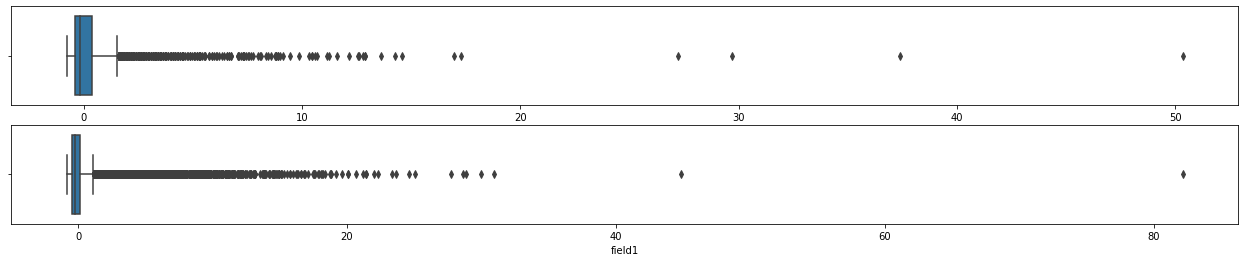

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(22,4))
sns.boxplot(data=train_df[train_df['goal1'] == 1], x='field1', ax=axes[0])
sns.boxplot(data=train_df[train_df['goal1'] == 0], x='field1', ax=axes[1])

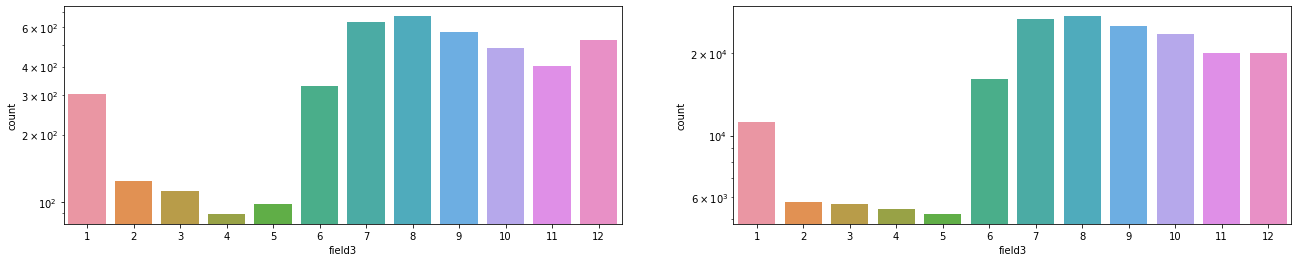

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))
sns.countplot(x='field3', data=train_df[train_df['goal1'] == 1], ax=axes[0], log=True);
sns.countplot(x='field3', data=train_df[train_df['goal1'] == 0], ax=axes[1], log=True);

In [ ]:
train_df['userid'].value_counts()

a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52    363
98e3b9eba8259c0fe0599cc0490a39e8d946942abcd43fa28ba1d2872f2a462b    222
a78176edc05b37528c4b559870f1c29c5cf1b0d7b2906db8e0a323d2b83e0bf4    185
6f88521de0b6c0f34e8c6675387055bc4b62331e681b5676549cadd149073f67    177
13a81409741819982c3bbc5452664081bfe7687c3c188ae4734d3c653985a1fa    149
                                                                   ... 
7496aa96141a4b7ef60d44c9848d8c38dfdd2b56cf609eb7757bafa1134e78c6      1
3dfbb95617b3f2ce9a7d19ba0baa49a264f6bdd43015b55c61ec4048d35c8057      1
f2d50774f6a5e5c7b5e22bc45cedb8d3337af9e158cd33fa7fdaa6fe194fe05d      1
6c7f0ffb1e4b56e76ebc00d27ccaa5ac0c8d1dcc52eb8d3f2b3ea02ead9ccbbb      1
4aac6962a9857086139d0f1f6333a9c0617acfa15af7cfa7eabdf99672792022      1
Name: userid, Length: 113902, dtype: int64

In [ ]:
train_df[(train_df['userid'] == 'a4837464e50075c4f8b5820dab011496ba1f04a985ab2782f5cafe6dda94ed52') & (train_df['goal1'] == 1)]

,userid,field0,field1,field2,field3,field4,field5,field6,field7,field8,field9,field10,field11,field12,field13,field14,field15,field16,field17,field18,field19,field20,field21,field22,field23,field24,field25,field26,field27,field28,field29,indicator_goal21,indicator_goal22,indicator_goal23,indicator_goal24,indicator_goal25,goal1
orderid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
63657,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,2.786632,8,11,71,0,2,2,1,0,1,15,37,201,5.501613,1,93,2,2,3,4,1,17,18,1,1,5,3,0,3,1,1,1,1,0,1
74405,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,2,-0.471365,4,4,271,0,0,1,1,0,0,8,9,2,-0.521242,1,0,1,3,3,3,2,1,11,1,1,5,3,0,2,1,1,0,0,0,1
83155,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,-0.083509,6,6,5,0,0,1,1,0,1,10,9,3,0.319156,1,5,1,4,2,2,1,16,18,1,1,12,3,0,2,1,1,1,1,0,1
90262,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,6,-0.471365,5,5,275,0,0,1,1,0,0,18,9,3,-0.101043,1,9,1,1,3,3,2,16,10,1,1,5,3,0,2,1,1,1,1,0,1
108372,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,7.363342,9,11,91,0,0,2,1,0,1,19,37,5,6.482078,2,63,1,3,3,3,1,268,5,2,5,5,3,0,3,1,1,0,1,0,1
125258,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,2.321204,9,9,95,0,6,2,0,0,1,16,73,5,1.999953,2,4,1,2,3,6,1,114,1,1,38,5,3,1,3,1,1,0,1,0,1
146256,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,-0.083509,6,6,12,0,0,1,1,0,0,15,19,2,0.319156,1,2,1,2,2,4,1,1,21,1,1,12,3,0,2,1,1,1,0,1,1
163864,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,0,4.570773,8,9,69,0,0,2,1,0,1,15,37,5,9.003273,1,21,1,2,3,2,1,268,4,1,5,5,3,0,3,1,1,0,0,0,1
164565,a4837464e50075c4f8b5820dab011496ba1f04a985ab27...,2,4.570773,8,9,68,0,0,2,1,0,1,15,37,5,9.003273,1,21,1,2,3,2,1,268,4,1,5,5,3,0,3,1,1,0,0,0,1


# No EDA

In [ ]:
train_df['field1'] = np.e ** train_df['field1'] 
train_df['field14'] = np.e ** train_df['field14']

test_df['field1'] = np.e ** test_df['field1'] 
test_df['field14'] = np.e ** test_df['field14']

In [ ]:
train_df['field1_field14_ratio'] = train_df['field1'] / train_df['field14']
test_df['field1_field14_ratio'] = test_df['field1'] / test_df['field14']

In [ ]:
double_features = []

for feature in double_features:

    f1, f2 = feature.split('__')
    train_df[feature] = train_df[f1].astype(str) + '_' + train_df[f2].astype(str)
    test_df[feature] = test_df[f1].astype(str) + '_' + test_df[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_df[feature].astype(str).values) + list(test_df[feature].astype(str).values))
    train_df[feature] = le.transform(list(train_df[feature].astype(str).values))
    test_df[feature] = le.transform(list(test_df[feature].astype(str).values))

In [ ]:
categorical_features = ['field2', 'field3', 'field11', 'field15', 'field18', 'field19', 'field20', 'field23', 'field24', 'field25', 'field27', 'field28', 'field29', 'userid', 'field9']
categorical_features += ['field5', 'field7', 'field8', 'field10', 'field21', 'indicator_goal21', 'indicator_goal22', 'indicator_goal23', 'indicator_goal24', 'indicator_goal25']
categorical_features += double_features

In [ ]:
non_binary_features = []

for col in [x for x in train_df.columns if not x in categorical_features]:
    if train_df[col].nunique() > 2:
        non_binary_features.append(col)

non_binary_features.remove('field4')
print(non_binary_features)

['field0', 'field1', 'field6', 'field12', 'field13', 'field14', 'field16', 'field17', 'field22', 'field26', 'field1_field14_ratio']


In [ ]:
log_cols = ['field0', 'field1', 'field6', 'field12', 'field13', 'field14', 'field16', 'field17', 'field22', 'field1_field14_ratio']

for col in log_cols:
    train_df[col] = np.log(train_df[col] + 1)
    test_df[col] = np.log(test_df[col] + 1)

In [ ]:
train_df, test_df = uid_aggregation(train_df, test_df, non_binary_features, ['userid'], ['median', 'std'])

In [ ]:
for col in tqdm_notebook(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

In [ ]:
X = train_df.drop(['goal1', 'field9'], axis=1)
y = train_df['goal1']
X_test = test_df.drop(['field9'], axis=1).copy()

In [ ]:
X.shape, y.shape, X_test.shape

((196056, 59), (196056,), (455011, 59))

# LGBM

In [ ]:
params = {'num_leaves': 493,
          'min_child_weight': 0.008023947837732857,
          'feature_fraction': 0.5341568665265988,
          'bagging_fraction': 0.32474760774990463,
          'min_data_in_leaf': 33,
          'objective': 'binary',
          'max_depth': 8,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.7722447692966574,
          'reg_lambda': 1.1987156815341724,
          'random_state': 47,
         }

In [ ]:
preds = np.zeros(len(X_test))
oof = np.zeros(len(X))

folds = KFold(n_splits=5, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    10000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=500)
    
    preds += clf.predict(X_test)
    oof[test_idx] = clf.predict(X.iloc[test_idx])
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('OOF AUC:', roc_auc_score(y, oof))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.887688	valid_1's auc: 0.691887
[1000]	training's auc: 0.929753	valid_1's auc: 0.697388
[1500]	training's auc: 0.949664	valid_1's auc: 0.697064
Early stopping, best iteration is:
[1068]	training's auc: 0.933549	valid_1's auc: 0.697773
Fold 1 finished in 0:02:34.362424
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.887096	valid_1's auc: 0.70797
[1000]	training's auc: 0.92652	valid_1's auc: 0.711085
[1500]	training's auc: 0.94924	valid_1's auc: 0.711003
Early stopping, best iteration is:
[1289]	training's auc: 0.940718	valid_1's auc: 0.711582
Fold 2 finished in 0:02:55.727558
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.888725	valid_1's auc: 0.705627
Early stopping, best iteration is:
[340]	training's auc: 0.864734	valid_1's auc: 0.706557
Fold 3 finished in 0:01:10.5

#### test
* defatult starter: 0.70027
* ratio feature: 0.70037
* loged features + median: 0.702

| OOF | LB | Desc |
| --- | --- | --- |
| 0.68365 | 0.6715850 | 2 folds starter |
| 0.68763 | 0.673887 | 2 folds with shuffle |
| 0.690581 | 0.6753480 |5 folds with shuffle | 
| 0.70964| 0.6878010 | user aggs |
| 0.71213 | 0.688 | loged

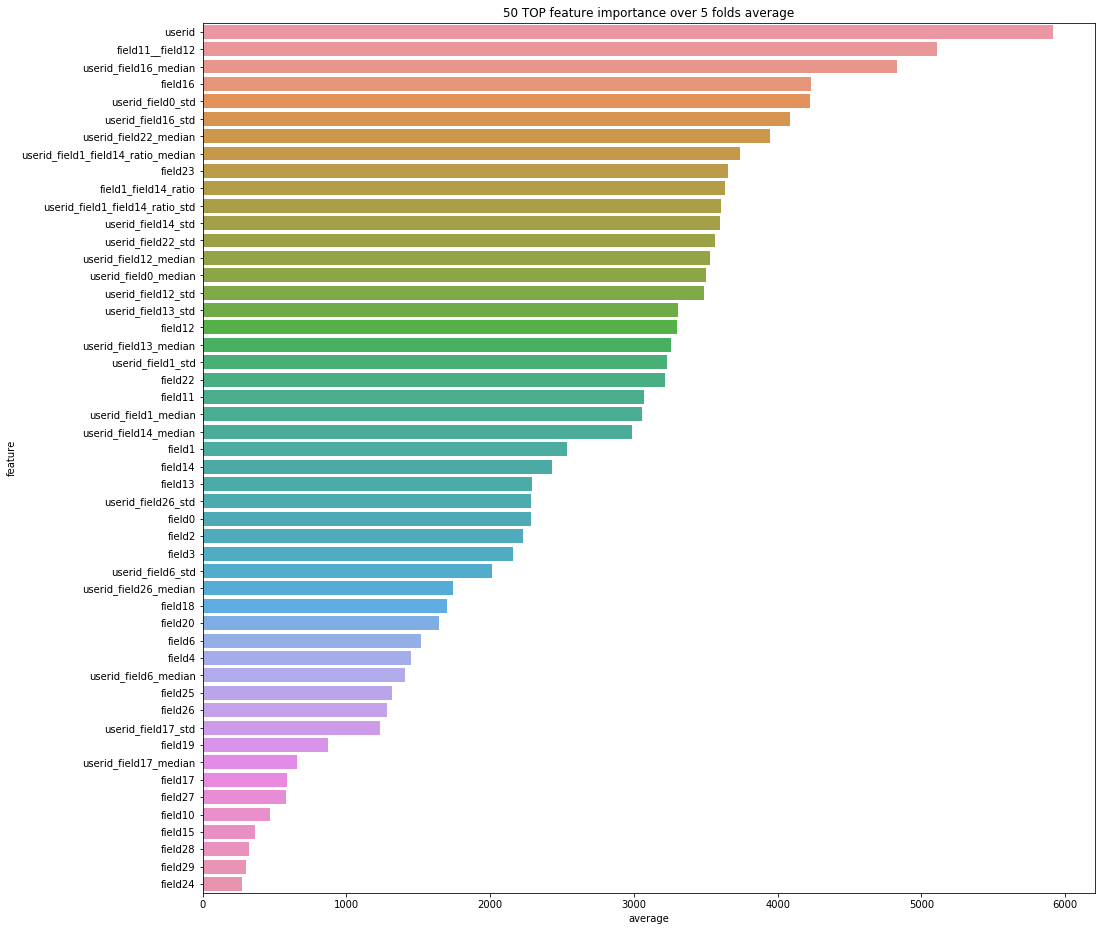

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
sample_submission['proba'] = preds / folds.n_splits

In [ ]:
sample_submission.to_csv('onetwotrip_loged_11_12.csv', index=False)

# Catboost

In [ ]:
categorical_features = ['userid']

print(categorical_features)

['userid']


In [ ]:
!pip install catboost

     |████████████████████████████████| 63.0MB 121kB/s 


In [ ]:
from catboost import CatBoostClassifier

cat_params = {
                'n_estimators':5000,
                'learning_rate': 0.01,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed': 42,
                'metric_period':500,
                'od_wait':500,
                'task_type':'GPU',
                'depth': 8,
                } 

In [ ]:
preds = np.zeros(len(X_test))
oof = np.zeros(len(X))

folds = KFold(n_splits=5, shuffle=True, random_state=47)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    estimator = CatBoostClassifier(**cat_params)        
    estimator.fit(
            X.iloc[trn_idx,:],y[trn_idx],
            eval_set=(X.iloc[test_idx,:], y[test_idx]),
            cat_features=categorical_features,
            use_best_model=True,
            verbose=True)
    
    preds += estimator.predict_proba(X_test)[:,1]
    oof[test_idx] = estimator.predict_proba(X.iloc[test_idx])[:,1]
    feature_importances['fold_{}'.format(fold + 1)] = estimator.get_feature_importance()
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('OOF AUC:', roc_auc_score(y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 0.5854073	test: 0.5570266	best: 0.5570266 (0)	total: 52ms	remaining: 4m 20s
500:	learn: 0.7329913	test: 0.6879663	best: 0.6879804 (499)	total: 21.6s	remaining: 3m 13s
1000:	learn: 0.7637309	test: 0.6945052	best: 0.6945052 (1000)	total: 42.8s	remaining: 2m 51s
1500:	learn: 0.7893768	test: 0.6973618	best: 0.6974149 (1478)	total: 1m 3s	remaining: 2m 29s
2000:	learn: 0.8104636	test: 0.6988011	best: 0.6988011 (2000)	total: 1m 24s	remaining: 2m 6s
2500:	learn: 0.8289191	test: 0.6993774	best: 0.6994533 (2283)	total: 1m 45s	remaining: 1m 45s
3000:	learn: 0.8455370	test: 0.6997496	best: 0.6999774 (2976)	total: 2m 5s	remaining: 1m 23s
bestTest = 0.6999773681
bestIteration = 2976
Shrink model to first 2977 iterations.
Fold 1 finished in 0:03:44.078461
Training on fold 2
0:	learn: 0.6068378	test: 0.6019305	best: 0.6019305 (0)	total: 46.7ms	remaining: 3m 53s
500:	learn: 0.7280057	test: 0.6953963	best: 0.6954778 (495)	total: 21.5s	remaining: 3m 13s
1000:	learn: 0.7599003

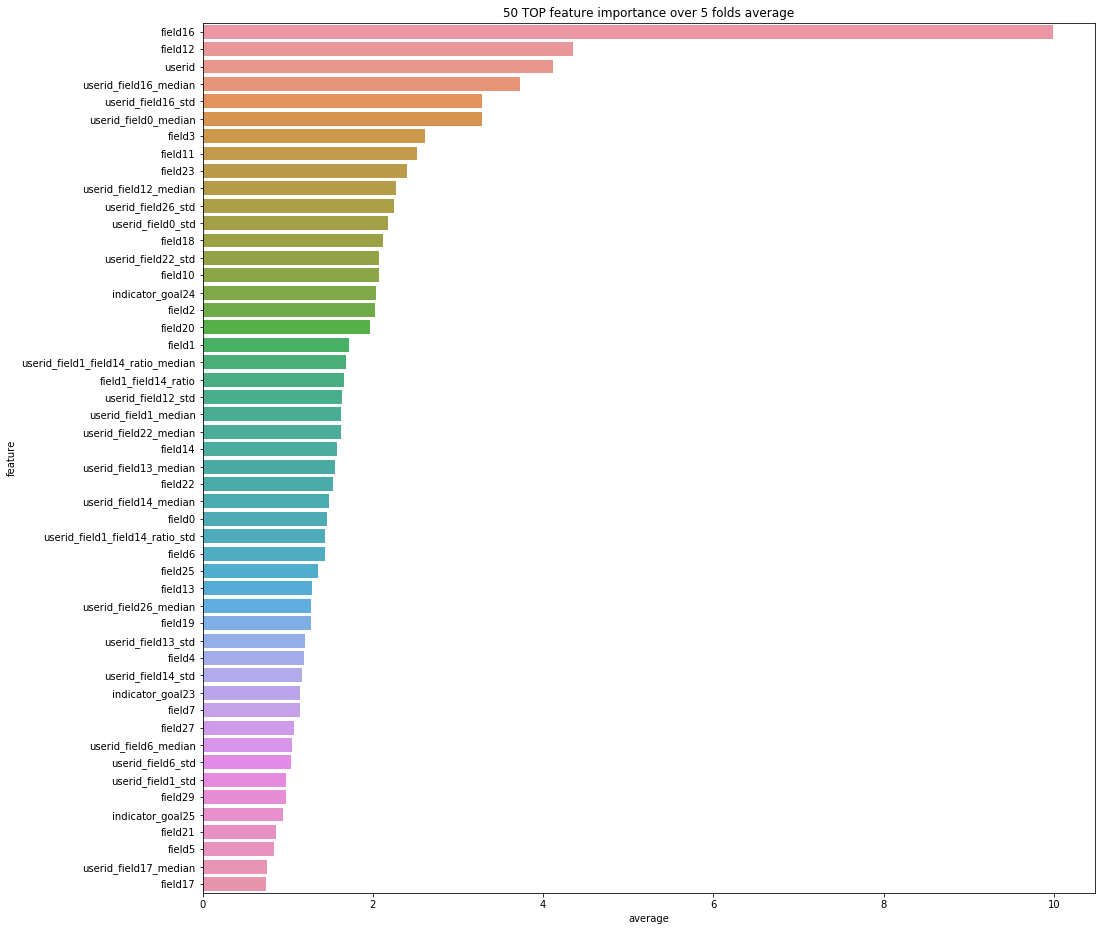

In [ ]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [ ]:
sample_submission['proba'] = preds / folds.n_splits

In [ ]:
sample_submission.to_csv('catboost_userid_cat.csv', index=False)

# Blend

In [ ]:
sub1 = pd.read_csv('catboost_userid_cat.csv')
sub2 = pd.read_csv('onetwotrip_loged.csv')

In [ ]:
outs = [sub1['proba'], sub2['proba']]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

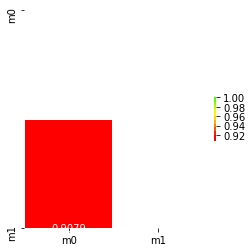

In [ ]:
# check correlation
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

In [ ]:
sample_submission['proba'] = 0.3 * sub1['proba'] + 0.7 * sub2['proba']
sample_submission.to_csv('blend_lgbm_catboost_3_7.csv', index=False)

In [ ]:
sample_submission.head()

,orderid,proba
0,0,0.009017
1,1,0.006189
2,2,0.041454
3,3,0.023680
4,4,0.004766


#Feature Selection

In [ ]:
params = {'num_leaves': 493,
          'min_child_weight': 0.008023947837732857,
          'feature_fraction': 0.5341568665265988,
          'bagging_fraction': 0.32474760774990463,
          'min_data_in_leaf': 33,
          'objective': 'binary',
          'max_depth': 6,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.7722447692966574,
          'reg_lambda': 1.1987156815341724,
          'random_state': 47,
          'n_estimators': 500,
         }

In [ ]:
!pip install mlxtend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
folds = KFold(n_splits=2, shuffle=True, random_state=47)

clf = LGBMClassifier(**params)

selector = SequentialFeatureSelector(clf, scoring='roc_auc', verbose=2, 
                                     k_features=20, forward=True, n_jobs=-1, cv = folds)

selector.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  4.5min finished

[2019-11-26 13:07:08] Features: 1/20 -- score: 0.6242325341220375[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.5min finished

[2019-11-26 13:11:39] Features: 2/20 -- score: 0.6653599073210192[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  5.1min finished

[2019-11-26 13:16:47] Features: 3/20 -- score: 0.670525928209416[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  58 out of

SequentialFeatureSelector(clone_estimator=True,
                          cv=KFold(n_splits=2, random_state=47, shuffle=True),
                          estimator=LGBMClassifier(bagging_fraction=0.32474760774990463,
                                                   bagging_seed=11,
                                                   boosting_type='gbdt',
                                                   class_weight=None,
                                                   colsample_bytree=1.0,
                                                   feature_fraction=0.5341568665265988,
                                                   importance_type='split',
                                                   learning_rate=0.006883242363721497,
                                                   max_depth=6, metric='...
                                                   min_data_in_leaf=33,
                                                   min_split_gain=0.0,
                              

In [ ]:
selector.subsets_[20]['feature_names']

('field0',
 'field2',
 'field4',
 'field6',
 'field12',
 'field14',
 'field16',
 'field18',
 'field19',
 'field25',
 'indicator_goal24',
 'userid_field0_mean',
 'userid_field0_std',
 'userid_field1_std',
 'userid_field12_std',
 'userid_field13_mean',
 'userid_field13_std',
 'userid_field14_mean',
 'userid_field16_mean',
 'userid_field26_mean')